In [1]:
import numpy as np
import pandas as pd
import os
%matplotlib notebook
import matplotlib.pyplot as plt


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_pinball_loss

from sklearn.metrics import r2_score
from scipy import stats

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import keras
import tensorflow as tf

import pickle
from sklearn.decomposition import IncrementalPCA
from scipy import sparse

2023-06-29 05:41:52.752158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path = '../DATA'

trainFile0 = 'train_augmented.csv'
testFile0 = 'test_augmented.csv'

trainFile = 'train_augmented_engineered.csv'
testFile = 'test_augmented_engineered.csv'

In [3]:
# Load all data
train_df0 = pd.read_csv(os.path.join(path, trainFile0),
                       header = 0,
                       index_col='id')
test_df0 = pd.read_csv(os.path.join(path, testFile0),
                      header = 0,
                      index_col='id')

train_df = pd.read_csv(os.path.join(path, trainFile),
                       header = 0,
                       index_col='id')
test_df = pd.read_csv(os.path.join(path, testFile),
                      header = 0,
                      index_col='id')

In [4]:
# Undo target encoding
train_df0_filt = train_df0[['state', 'occupation']]
test_df0_filt = test_df0[['state', 'occupation']]

train_df = pd.merge(train_df.reset_index(names='id'), train_df0_filt.reset_index(names='id'), on=['id']).set_index('id')
train_df = train_df.drop(columns=['state_mean', 'state_q1','state_q2', 'state_q3', 'state_q4', 'state_q5', 'occupation_mean',
       'occupation_q1', 'occupation_q2', 'occupation_q3', 'occupation_q4',
       'occupation_q5'])
train_df[['state', 'occupation']] = train_df[['state', 'occupation']] - 1

test_df = pd.merge(test_df.reset_index(names='id'), test_df0_filt.reset_index(names='id'),  on=['id']).set_index('id')
test_df = test_df.drop(columns=['state_mean', 'state_q1','state_q2', 'state_q3', 'state_q4', 'state_q5', 'occupation_mean',
       'occupation_q1', 'occupation_q2', 'occupation_q3', 'occupation_q4',
       'occupation_q5'])
test_df[['state', 'occupation']] = test_df[['state', 'occupation']] - 1




## Data imputation

In [5]:
# Create new category rather than impute for now!
for col in ['occupation','state','region']:
    df_col = train_df[col]
    max_value = np.nanmax(df_col[df_col.notna()])+1
    train_df[col] = train_df[col].replace(np.nan, max_value)
    test_df[col] = test_df[col].replace(np.nan, max_value)


## Transform categorical/ordinal variables

In [6]:
catCols = ['urban', 'race', 'region', 'state', 'marital', 'occupation', 'educationCat']

# no need to do this, will use embedding

## Scale numerical variables

In [7]:
allCols = list(test_df.columns)
numericalCols = np.setdiff1d(allCols, catCols).tolist()

# log transform the ones with a long tail before scaling
logTransCols = ['familysize', 'income', 'AnnualExpenditureByFamilySize_per_education', 'CPIUrban_times_familySize', 'UnemploymentRateByAge', 'AnnualExpenditureByIncome']
for col in logTransCols:
    if col == 'income':
        train_df[col] = np.log(train_df[col]+1)
        test_df[col] = np.log(test_df[col]+1)
    else:
        train_df[col] = np.log(train_df[col])
        test_df[col] = np.log(test_df[col])

# Scale
scaler = StandardScaler()
scaler.fit(train_df[numericalCols])
train_df[numericalCols] = scaler.transform(train_df[numericalCols])
test_df[numericalCols] = scaler.transform(test_df[numericalCols])

# Drop due to ugly distribution
train_df = train_df.drop(columns=['education_per_income'])
test_df = test_df.drop(columns=['education_per_income'])
numericalCols.remove('education_per_income')

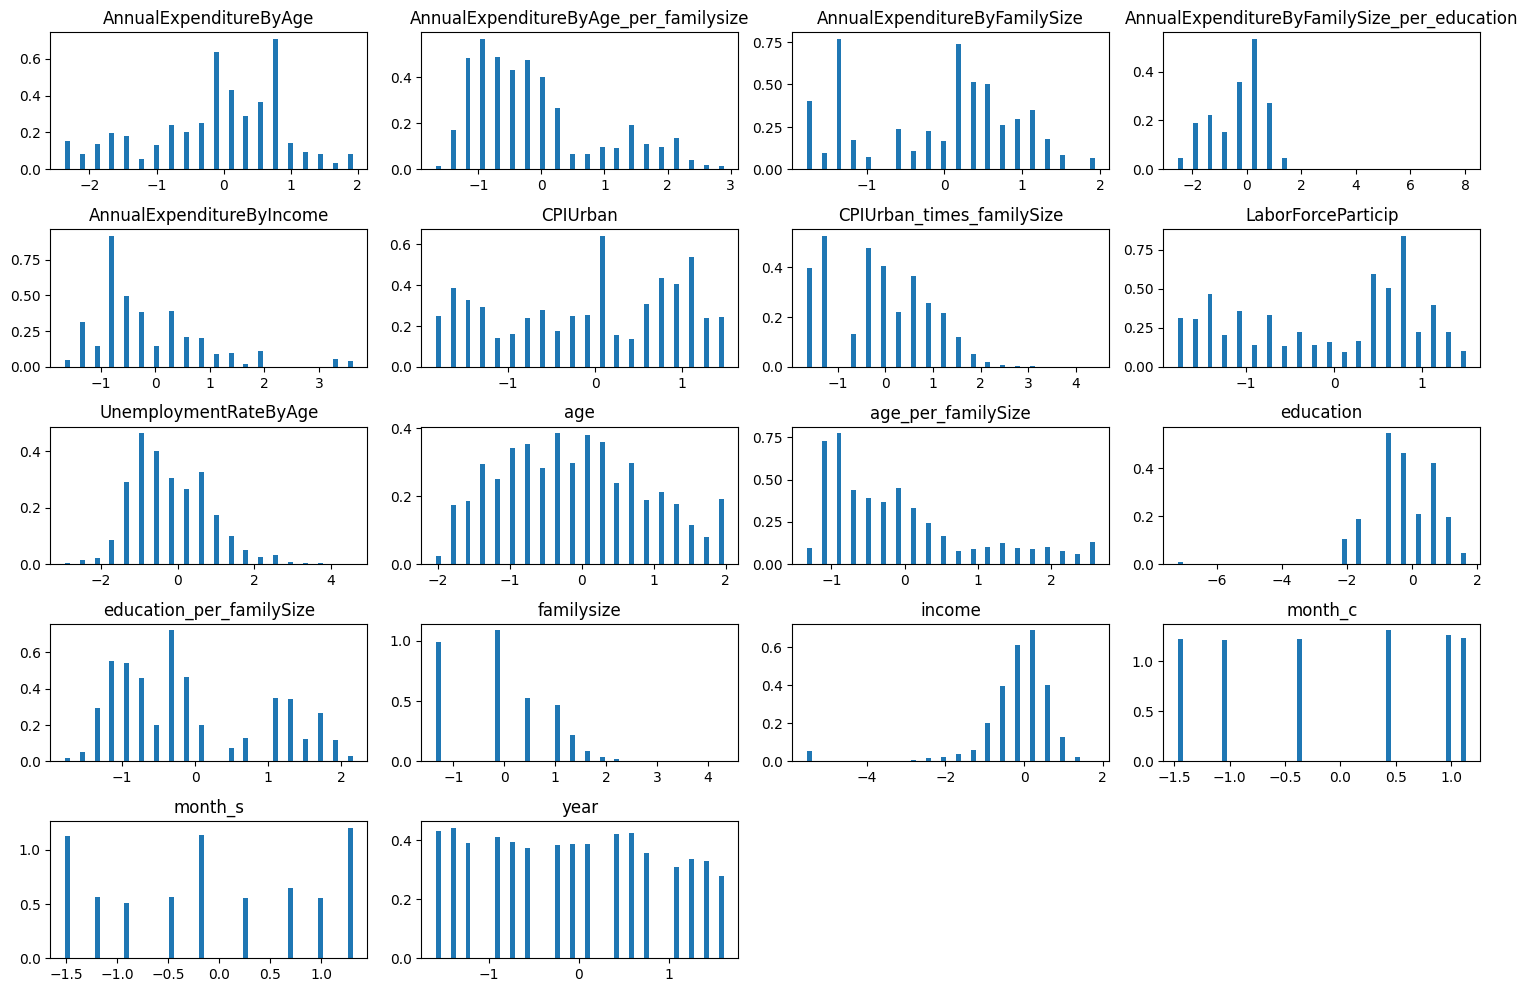

In [122]:
plt.figure(figsize=(15,10))
for i, col in enumerate(numericalCols):
    plt.subplot(5,4,i+1)
    
    colVal = train_df[col]
    
    a_heights, a_bins = np.histogram(colVal, bins=20, density=True)
    width = (a_bins[1] - a_bins[0])/3
    
    b_heights, b_bins = np.histogram(colVal, bins=a_bins, density=True)
    plt.bar(b_bins[:-1], b_heights, width=width)

    plt.title(col)
    
plt.tight_layout(pad=1.0)

## Prepare data for training

In [8]:
train_arr = train_df.to_numpy()
weight_arr = train_arr[:,0]
x_inds = np.concatenate((np.arange(1,10), np.arange(11,train_arr.shape[1])))
X_arr = train_arr[:, x_inds]
y_arr = train_arr[:,10]

randomState = 0

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X_arr, 
                                                                                 y_arr, 
                                                                                 weight_arr, 
                                                                                 test_size=0.3, 
                                                                                 random_state=randomState)

X_train, X_valid, y_train, y_valid, weights_train, weights_valid = train_test_split(X_train, 
                                                                                    y_train, 
                                                                                    weights_train, 
                                                                                    test_size=0.15, 
                                                                                    random_state=randomState)



In [9]:
x_catColInds = np.array([4, 5, 6, 7, 15, 23, 24])
x_numColInds = np.setdiff1d(np.arange(X_arr.shape[1]),x_catColInds)

# categories will be treated as separate inputs so they can be embedded
X_train_inputs = []
X_valid_inputs = []
X_test_inputs = []
for i in x_catColInds:
    inp_i = X_train[:, i]
    X_train_inputs.append(inp_i[:, np.newaxis])

    inp_i = X_valid[:, i]
    X_valid_inputs.append(inp_i[:, np.newaxis])
    
    inp_i = X_test[:, i]
    X_test_inputs.append(inp_i[:, np.newaxis])

    
X_train_inputs.append(X_train[:, x_numColInds])
X_valid_inputs.append(X_valid[:, x_numColInds])
X_test_inputs.append(X_test[:, x_numColInds])

# will scale down target values, that way we dont have to wait for weights and biases to grow
# predictions will have to be scaled up again!
y_train_gt = y_train[:,np.newaxis]
y_train_scaled = y_train_gt/1000.
y_valid_gt = y_valid[:,np.newaxis]
y_valid_scaled = y_valid_gt/1000.
y_test_gt = y_test[:,np.newaxis]
y_test_scaled = y_test_gt/1000.


sample_weights_train = weights_train[:,np.newaxis]
sample_weights_train_norm = sample_weights_train/np.max(sample_weights_train)

sample_weights_valid = weights_valid[:,np.newaxis]
sample_weights_valid_norm = sample_weights_valid/np.max(sample_weights_train)

sample_weights_test = weights_test[:,np.newaxis]
sample_weights_test_norm = sample_weights_test/np.max(sample_weights_train)


## Try MLP with random guesses for hyperparameters/architecture

Single layer MLP with additional embeddings for categorical variables.
Plus dropout for regularization.

A single shared network across quantiles with multiple readout heads, one per quantile. Shared representations may help learn better representations?

In [10]:
cat_input_dim = [2, 6, 5, 5, 18, 56, 19]
cat_output_dim = []
for c in cat_input_dim:
    if c <= 10:
        o_dim = 2
    elif c <= 20:
        o_dim = 4
    else:
        o_dim = 8
    cat_output_dim.append(o_dim)

In [11]:
# set seed
tf.keras.utils.set_random_seed(randomState)

In [17]:
# this is just for an example run
quantiles = [0.1, 0.5, 0.9]

# construct categorical inputs
catEmbeddings = []
catInputs = []
for i in range(len(catCols)):
    catInput_i = keras.Input(shape=(1,))    
    catInputs.append(catInput_i)
    emb_i = keras.layers.Embedding(cat_input_dim[i], 
                                   cat_output_dim[i])
    catEmbeddings.append(keras.layers.Flatten()(emb_i(catInput_i)))
    
# numerical inputs
numInputs = keras.Input(shape=(18,))

# construct overal network input
netInput = keras.layers.concatenate(catEmbeddings+[numInputs])

# hidden layer
dense1 = keras.layers.Dense(2000, activation="relu", kernel_constraint=keras.constraints.MaxNorm(5)) #kernel_regularizer=keras.regularizers.L2(1e-4))
hidden1 = dense1(netInput)

hidden1 = keras.layers.Dropout(0.3)(hidden1)

# Now, create an output for each quantile
outputs = []
for i, quantile in enumerate(quantiles):
    o_layer_i = keras.layers.Dense(1, name = f'quantile_{i}')
    outputs.append(o_layer_i(hidden1))

model = keras.Model(inputs=catInputs+[numInputs], outputs=outputs)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

### Define custom loss

In [12]:
class PinballLoss(keras.losses.Loss):

    def __init__(self, q, reduction):
        self.q = q
        super().__init__(reduction)

    def call(self, y_true, y_preds):
        e = y_true-y_preds
        loss = tf.math.maximum(self.q*e, (self.q-1)*e)
        return loss

In [48]:
losses = dict()
lossWeights = dict()
for i, q in enumerate(quantiles):
    losses[f'quantile_{i}'] = PinballLoss(q, reduction=tf.keras.losses.Reduction.SUM)#_OVER_BATCH_SIZE)
    lossWeights[f'quantile_{i}'] = 1./len(quantiles)


In [213]:
# compile and train model with early stopping based on validation performance

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=losses, loss_weights=lossWeights)

es =keras.callbacks.EarlyStopping(monitor="val_loss",
                                  min_delta=0,
                                  patience=10,
                                  mode="min",
                                  restore_best_weights = True)

model.fit(x = X_train_inputs,
          y = y_train_scaled,
          sample_weight=sample_weights_train_norm,
          batch_size = 100,
          epochs = 50,
          validation_data = (X_valid_inputs, y_valid_scaled, sample_weights_valid_norm),
          callbacks=[es])

Epoch 1/50
4411/4415 [============================>.] - ETA: 0s - loss: 5.7137 - quantile_0_loss: 2.6092 - quantile_1_loss: 7.7406 - quantile_2_loss: 6.7912WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 38s 8ms/step - loss: 5.7136 - quantile_0_loss: 2.6092 - quantile_1_loss: 7.7405 - quantile_2_loss: 6.7910 - val_loss: 5.4182 - val_quantile_0_loss: 2.5476 - val_quantile_1_loss: 7.4657 - val_quantile_2_loss: 6.2414
Epoch 2/50
4408/4415 [============================>.] - ETA: 0s - loss: 5.4698 - quantile_0_loss: 2.5747 - quantile_1_loss: 7.5192 - quantile_2_loss: 6.3157WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 21s 5ms/step - loss: 5.4704 - quantile_0_loss: 2.5749 - quantile_1_loss: 7.5203 - quantile_2_loss: 6.3160 - val_loss: 5.4087 - val_quantile_0_loss: 2.5395 - val_quantile_1_loss: 7.4717 - val_quantile_2_loss: 6.2150
Epoch 3/50
4412/4415 [============================>.] - ETA: 0s - loss: 5.4544 - quantile_0_loss: 2.5672 - quantile_1_loss: 7.5042 - quantile_2_loss: 6.2917WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 21s 5ms/step - loss: 5.4548 - quantile_0_loss: 2.5672 - quantile_1_loss: 7.5048 - quantile_2_loss: 6.2926 - val_loss: 5.3908 - val_quantile_0_loss: 2.5326 - val_quantile_1_loss: 7.4440 - val_quantile_2_loss: 6.1958
Epoch 4/50
4412/4415 [============================>.] - ETA: 0s - loss: 5.4452 - quantile_0_loss: 2.5614 - quantile_1_loss: 7.4936 - quantile_2_loss: 6.2807WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 21s 5ms/step - loss: 5.4446 - quantile_0_loss: 2.5613 - quantile_1_loss: 7.4929 - quantile_2_loss: 6.2795 - val_loss: 5.3827 - val_quantile_0_loss: 2.5327 - val_quantile_1_loss: 7.4293 - val_quantile_2_loss: 6.1861
Epoch 5/50
4401/4415 [============================>.] - ETA: 0s - loss: 5.4396 - quantile_0_loss: 2.5586 - quantile_1_loss: 7.4869 - quantile_2_loss: 6.2732WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 17s 4ms/step - loss: 5.4376 - quantile_0_loss: 2.5580 - quantile_1_loss: 7.4849 - quantile_2_loss: 6.2700 - val_loss: 5.3772 - val_quantile_0_loss: 2.5251 - val_quantile_1_loss: 7.4264 - val_quantile_2_loss: 6.1800
Epoch 6/50
4413/4415 [============================>.] - ETA: 0s - loss: 5.4310 - quantile_0_loss: 2.5538 - quantile_1_loss: 7.4777 - quantile_2_loss: 6.2614WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 16s 4ms/step - loss: 5.4306 - quantile_0_loss: 2.5536 - quantile_1_loss: 7.4773 - quantile_2_loss: 6.2608 - val_loss: 5.3711 - val_quantile_0_loss: 2.5226 - val_quantile_1_loss: 7.4221 - val_quantile_2_loss: 6.1687
Epoch 7/50
4407/4415 [============================>.] - ETA: 0s - loss: 5.4268 - quantile_0_loss: 2.5505 - quantile_1_loss: 7.4757 - quantile_2_loss: 6.2541WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 15s 4ms/step - loss: 5.4273 - quantile_0_loss: 2.5506 - quantile_1_loss: 7.4757 - quantile_2_loss: 6.2555 - val_loss: 5.3679 - val_quantile_0_loss: 2.5225 - val_quantile_1_loss: 7.4189 - val_quantile_2_loss: 6.1624
Epoch 8/50
4407/4415 [============================>.] - ETA: 0s - loss: 5.4247 - quantile_0_loss: 2.5482 - quantile_1_loss: 7.4728 - quantile_2_loss: 6.2530WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 22s 5ms/step - loss: 5.4230 - quantile_0_loss: 2.5476 - quantile_1_loss: 7.4706 - quantile_2_loss: 6.2507 - val_loss: 5.3715 - val_quantile_0_loss: 2.5204 - val_quantile_1_loss: 7.4246 - val_quantile_2_loss: 6.1696
Epoch 9/50
4413/4415 [============================>.] - ETA: 0s - loss: 5.4202 - quantile_0_loss: 2.5451 - quantile_1_loss: 7.4682 - quantile_2_loss: 6.2471WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 26s 6ms/step - loss: 5.4196 - quantile_0_loss: 2.5449 - quantile_1_loss: 7.4675 - quantile_2_loss: 6.2465 - val_loss: 5.3604 - val_quantile_0_loss: 2.5164 - val_quantile_1_loss: 7.4095 - val_quantile_2_loss: 6.1552
Epoch 10/50
4407/4415 [============================>.] - ETA: 0s - loss: 5.4174 - quantile_0_loss: 2.5422 - quantile_1_loss: 7.4662 - quantile_2_loss: 6.2440WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 27s 6ms/step - loss: 5.4157 - quantile_0_loss: 2.5419 - quantile_1_loss: 7.4645 - quantile_2_loss: 6.2406 - val_loss: 5.3597 - val_quantile_0_loss: 2.5159 - val_quantile_1_loss: 7.4098 - val_quantile_2_loss: 6.1534
Epoch 11/50
4408/4415 [============================>.] - ETA: 0s - loss: 5.4117 - quantile_0_loss: 2.5398 - quantile_1_loss: 7.4600 - quantile_2_loss: 6.2354WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 28s 6ms/step - loss: 5.4123 - quantile_0_loss: 2.5397 - quantile_1_loss: 7.4604 - quantile_2_loss: 6.2367 - val_loss: 5.3580 - val_quantile_0_loss: 2.5132 - val_quantile_1_loss: 7.4061 - val_quantile_2_loss: 6.1547
Epoch 12/50
4415/4415 [==============================] - ETA: 0s - loss: 5.4101 - quantile_0_loss: 2.5383 - quantile_1_loss: 7.4577 - quantile_2_loss: 6.2343WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 28s 6ms/step - loss: 5.4101 - quantile_0_loss: 2.5383 - quantile_1_loss: 7.4577 - quantile_2_loss: 6.2343 - val_loss: 5.3588 - val_quantile_0_loss: 2.5139 - val_quantile_1_loss: 7.4102 - val_quantile_2_loss: 6.1523
Epoch 13/50
4409/4415 [============================>.] - ETA: 0s - loss: 5.4087 - quantile_0_loss: 2.5360 - quantile_1_loss: 7.4582 - quantile_2_loss: 6.2319WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 28s 6ms/step - loss: 5.4074 - quantile_0_loss: 2.5356 - quantile_1_loss: 7.4565 - quantile_2_loss: 6.2300 - val_loss: 5.3527 - val_quantile_0_loss: 2.5122 - val_quantile_1_loss: 7.4022 - val_quantile_2_loss: 6.1438
Epoch 14/50
4411/4415 [============================>.] - ETA: 0s - loss: 5.4045 - quantile_0_loss: 2.5340 - quantile_1_loss: 7.4538 - quantile_2_loss: 6.2258WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 25s 6ms/step - loss: 5.4051 - quantile_0_loss: 2.5341 - quantile_1_loss: 7.4544 - quantile_2_loss: 6.2268 - val_loss: 5.3543 - val_quantile_0_loss: 2.5091 - val_quantile_1_loss: 7.4061 - val_quantile_2_loss: 6.1477
Epoch 15/50
4415/4415 [==============================] - ETA: 0s - loss: 5.4025 - quantile_0_loss: 2.5324 - quantile_1_loss: 7.4516 - quantile_2_loss: 6.2235WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 26s 6ms/step - loss: 5.4025 - quantile_0_loss: 2.5324 - quantile_1_loss: 7.4516 - quantile_2_loss: 6.2235 - val_loss: 5.3509 - val_quantile_0_loss: 2.5081 - val_quantile_1_loss: 7.4010 - val_quantile_2_loss: 6.1434
Epoch 16/50
4407/4415 [============================>.] - ETA: 0s - loss: 5.4004 - quantile_0_loss: 2.5311 - quantile_1_loss: 7.4506 - quantile_2_loss: 6.2194WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 25s 6ms/step - loss: 5.4011 - quantile_0_loss: 2.5315 - quantile_1_loss: 7.4514 - quantile_2_loss: 6.2204 - val_loss: 5.3515 - val_quantile_0_loss: 2.5073 - val_quantile_1_loss: 7.4017 - val_quantile_2_loss: 6.1455
Epoch 17/50
4408/4415 [============================>.] - ETA: 0s - loss: 5.3982 - quantile_0_loss: 2.5304 - quantile_1_loss: 7.4476 - quantile_2_loss: 6.2166WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 28s 6ms/step - loss: 5.3971 - quantile_0_loss: 2.5301 - quantile_1_loss: 7.4463 - quantile_2_loss: 6.2149 - val_loss: 5.3479 - val_quantile_0_loss: 2.5056 - val_quantile_1_loss: 7.4003 - val_quantile_2_loss: 6.1378
Epoch 18/50
4407/4415 [============================>.] - ETA: 0s - loss: 5.3931 - quantile_0_loss: 2.5267 - quantile_1_loss: 7.4406 - quantile_2_loss: 6.2120WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 27s 6ms/step - loss: 5.3946 - quantile_0_loss: 2.5272 - quantile_1_loss: 7.4422 - quantile_2_loss: 6.2144 - val_loss: 5.3444 - val_quantile_0_loss: 2.5055 - val_quantile_1_loss: 7.3949 - val_quantile_2_loss: 6.1330
Epoch 19/50
4414/4415 [============================>.] - ETA: 0s - loss: 5.3945 - quantile_0_loss: 2.5270 - quantile_1_loss: 7.4444 - quantile_2_loss: 6.2121WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 28s 6ms/step - loss: 5.3944 - quantile_0_loss: 2.5270 - quantile_1_loss: 7.4442 - quantile_2_loss: 6.2120 - val_loss: 5.3520 - val_quantile_0_loss: 2.5086 - val_quantile_1_loss: 7.4101 - val_quantile_2_loss: 6.1372
Epoch 20/50
4407/4415 [============================>.] - ETA: 0s - loss: 5.3906 - quantile_0_loss: 2.5252 - quantile_1_loss: 7.4394 - quantile_2_loss: 6.2072WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 29s 7ms/step - loss: 5.3916 - quantile_0_loss: 2.5256 - quantile_1_loss: 7.4405 - quantile_2_loss: 6.2088 - val_loss: 5.3502 - val_quantile_0_loss: 2.5068 - val_quantile_1_loss: 7.4037 - val_quantile_2_loss: 6.1400
Epoch 21/50
4406/4415 [============================>.] - ETA: 0s - loss: 5.3917 - quantile_0_loss: 2.5257 - quantile_1_loss: 7.4415 - quantile_2_loss: 6.2080WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 28s 6ms/step - loss: 5.3901 - quantile_0_loss: 2.5251 - quantile_1_loss: 7.4397 - quantile_2_loss: 6.2055 - val_loss: 5.3463 - val_quantile_0_loss: 2.5124 - val_quantile_1_loss: 7.3984 - val_quantile_2_loss: 6.1282
Epoch 22/50
4412/4415 [============================>.] - ETA: 0s - loss: 5.3878 - quantile_0_loss: 2.5236 - quantile_1_loss: 7.4388 - quantile_2_loss: 6.2011WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 26s 6ms/step - loss: 5.3877 - quantile_0_loss: 2.5237 - quantile_1_loss: 7.4384 - quantile_2_loss: 6.2011 - val_loss: 5.3406 - val_quantile_0_loss: 2.5008 - val_quantile_1_loss: 7.3911 - val_quantile_2_loss: 6.1298
Epoch 23/50
4407/4415 [============================>.] - ETA: 0s - loss: 5.3867 - quantile_0_loss: 2.5226 - quantile_1_loss: 7.4352 - quantile_2_loss: 6.2025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 19s 4ms/step - loss: 5.3865 - quantile_0_loss: 2.5223 - quantile_1_loss: 7.4347 - quantile_2_loss: 6.2024 - val_loss: 5.3398 - val_quantile_0_loss: 2.4996 - val_quantile_1_loss: 7.3925 - val_quantile_2_loss: 6.1274
Epoch 24/50
4405/4415 [============================>.] - ETA: 0s - loss: 5.3851 - quantile_0_loss: 2.5210 - quantile_1_loss: 7.4354 - quantile_2_loss: 6.1990WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 20s 5ms/step - loss: 5.3843 - quantile_0_loss: 2.5208 - quantile_1_loss: 7.4342 - quantile_2_loss: 6.1980 - val_loss: 5.3383 - val_quantile_0_loss: 2.5011 - val_quantile_1_loss: 7.3873 - val_quantile_2_loss: 6.1264
Epoch 25/50
4403/4415 [============================>.] - ETA: 0s - loss: 5.3802 - quantile_0_loss: 2.5195 - quantile_1_loss: 7.4292 - quantile_2_loss: 6.1920WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 18s 4ms/step - loss: 5.3820 - quantile_0_loss: 2.5196 - quantile_1_loss: 7.4311 - quantile_2_loss: 6.1955 - val_loss: 5.3436 - val_quantile_0_loss: 2.4991 - val_quantile_1_loss: 7.3997 - val_quantile_2_loss: 6.1321
Epoch 26/50
4405/4415 [============================>.] - ETA: 0s - loss: 5.3809 - quantile_0_loss: 2.5201 - quantile_1_loss: 7.4295 - quantile_2_loss: 6.1931WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 18s 4ms/step - loss: 5.3808 - quantile_0_loss: 2.5200 - quantile_1_loss: 7.4293 - quantile_2_loss: 6.1932 - val_loss: 5.3399 - val_quantile_0_loss: 2.5054 - val_quantile_1_loss: 7.3911 - val_quantile_2_loss: 6.1231
Epoch 27/50
4409/4415 [============================>.] - ETA: 0s - loss: 5.3815 - quantile_0_loss: 2.5190 - quantile_1_loss: 7.4313 - quantile_2_loss: 6.1943WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 22s 5ms/step - loss: 5.3803 - quantile_0_loss: 2.5192 - quantile_1_loss: 7.4298 - quantile_2_loss: 6.1917 - val_loss: 5.3415 - val_quantile_0_loss: 2.5013 - val_quantile_1_loss: 7.3953 - val_quantile_2_loss: 6.1278
Epoch 28/50
4408/4415 [============================>.] - ETA: 0s - loss: 5.3777 - quantile_0_loss: 2.5186 - quantile_1_loss: 7.4265 - quantile_2_loss: 6.1881WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 20s 4ms/step - loss: 5.3782 - quantile_0_loss: 2.5186 - quantile_1_loss: 7.4269 - quantile_2_loss: 6.1890 - val_loss: 5.3377 - val_quantile_0_loss: 2.4982 - val_quantile_1_loss: 7.3908 - val_quantile_2_loss: 6.1241
Epoch 29/50
4409/4415 [============================>.] - ETA: 0s - loss: 5.3777 - quantile_0_loss: 2.5171 - quantile_1_loss: 7.4272 - quantile_2_loss: 6.1887WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 19s 4ms/step - loss: 5.3770 - quantile_0_loss: 2.5171 - quantile_1_loss: 7.4265 - quantile_2_loss: 6.1875 - val_loss: 5.3340 - val_quantile_0_loss: 2.4969 - val_quantile_1_loss: 7.3839 - val_quantile_2_loss: 6.1212
Epoch 30/50
4406/4415 [============================>.] - ETA: 0s - loss: 5.3769 - quantile_0_loss: 2.5166 - quantile_1_loss: 7.4260 - quantile_2_loss: 6.1881WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 18s 4ms/step - loss: 5.3757 - quantile_0_loss: 2.5162 - quantile_1_loss: 7.4247 - quantile_2_loss: 6.1863 - val_loss: 5.3370 - val_quantile_0_loss: 2.4990 - val_quantile_1_loss: 7.3881 - val_quantile_2_loss: 6.1238
Epoch 31/50
4412/4415 [============================>.] - ETA: 0s - loss: 5.3754 - quantile_0_loss: 2.5156 - quantile_1_loss: 7.4236 - quantile_2_loss: 6.1870WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 18s 4ms/step - loss: 5.3746 - quantile_0_loss: 2.5153 - quantile_1_loss: 7.4227 - quantile_2_loss: 6.1857 - val_loss: 5.3342 - val_quantile_0_loss: 2.4996 - val_quantile_1_loss: 7.3827 - val_quantile_2_loss: 6.1205
Epoch 32/50
4407/4415 [============================>.] - ETA: 0s - loss: 5.3699 - quantile_0_loss: 2.5139 - quantile_1_loss: 7.4203 - quantile_2_loss: 6.1753WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 17s 4ms/step - loss: 5.3729 - quantile_0_loss: 2.5142 - quantile_1_loss: 7.4231 - quantile_2_loss: 6.1812 - val_loss: 5.3363 - val_quantile_0_loss: 2.4970 - val_quantile_1_loss: 7.3901 - val_quantile_2_loss: 6.1217
Epoch 33/50
4407/4415 [============================>.] - ETA: 0s - loss: 5.3733 - quantile_0_loss: 2.5147 - quantile_1_loss: 7.4221 - quantile_2_loss: 6.1831WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 17s 4ms/step - loss: 5.3722 - quantile_0_loss: 2.5143 - quantile_1_loss: 7.4209 - quantile_2_loss: 6.1814 - val_loss: 5.3335 - val_quantile_0_loss: 2.4972 - val_quantile_1_loss: 7.3840 - val_quantile_2_loss: 6.1192
Epoch 34/50
4413/4415 [============================>.] - ETA: 0s - loss: 5.3706 - quantile_0_loss: 2.5131 - quantile_1_loss: 7.4203 - quantile_2_loss: 6.1785WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 19s 4ms/step - loss: 5.3708 - quantile_0_loss: 2.5130 - quantile_1_loss: 7.4203 - quantile_2_loss: 6.1789 - val_loss: 5.3354 - val_quantile_0_loss: 2.4967 - val_quantile_1_loss: 7.3894 - val_quantile_2_loss: 6.1202
Epoch 35/50
4405/4415 [============================>.] - ETA: 0s - loss: 5.3675 - quantile_0_loss: 2.5118 - quantile_1_loss: 7.4172 - quantile_2_loss: 6.1736WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 18s 4ms/step - loss: 5.3669 - quantile_0_loss: 2.5117 - quantile_1_loss: 7.4169 - quantile_2_loss: 6.1720 - val_loss: 5.3329 - val_quantile_0_loss: 2.4947 - val_quantile_1_loss: 7.3861 - val_quantile_2_loss: 6.1178
Epoch 36/50
4405/4415 [============================>.] - ETA: 0s - loss: 5.3664 - quantile_0_loss: 2.5117 - quantile_1_loss: 7.4155 - quantile_2_loss: 6.1721WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 20s 5ms/step - loss: 5.3669 - quantile_0_loss: 2.5115 - quantile_1_loss: 7.4161 - quantile_2_loss: 6.1731 - val_loss: 5.3304 - val_quantile_0_loss: 2.4937 - val_quantile_1_loss: 7.3816 - val_quantile_2_loss: 6.1158
Epoch 37/50
4402/4415 [============================>.] - ETA: 0s - loss: 5.3661 - quantile_0_loss: 2.5110 - quantile_1_loss: 7.4146 - quantile_2_loss: 6.1725WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 18s 4ms/step - loss: 5.3659 - quantile_0_loss: 2.5111 - quantile_1_loss: 7.4146 - quantile_2_loss: 6.1718 - val_loss: 5.3306 - val_quantile_0_loss: 2.4963 - val_quantile_1_loss: 7.3794 - val_quantile_2_loss: 6.1161
Epoch 38/50
4414/4415 [============================>.] - ETA: 0s - loss: 5.3648 - quantile_0_loss: 2.5107 - quantile_1_loss: 7.4142 - quantile_2_loss: 6.1695WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 18s 4ms/step - loss: 5.3646 - quantile_0_loss: 2.5106 - quantile_1_loss: 7.4140 - quantile_2_loss: 6.1693 - val_loss: 5.3292 - val_quantile_0_loss: 2.4935 - val_quantile_1_loss: 7.3784 - val_quantile_2_loss: 6.1155
Epoch 39/50
4414/4415 [============================>.] - ETA: 0s - loss: 5.3635 - quantile_0_loss: 2.5096 - quantile_1_loss: 7.4115 - quantile_2_loss: 6.1694WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 17s 4ms/step - loss: 5.3634 - quantile_0_loss: 2.5096 - quantile_1_loss: 7.4113 - quantile_2_loss: 6.1692 - val_loss: 5.3309 - val_quantile_0_loss: 2.4961 - val_quantile_1_loss: 7.3823 - val_quantile_2_loss: 6.1144
Epoch 40/50
4406/4415 [============================>.] - ETA: 0s - loss: 5.3600 - quantile_0_loss: 2.5085 - quantile_1_loss: 7.4104 - quantile_2_loss: 6.1611WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 17s 4ms/step - loss: 5.3618 - quantile_0_loss: 2.5090 - quantile_1_loss: 7.4126 - quantile_2_loss: 6.1640 - val_loss: 5.3286 - val_quantile_0_loss: 2.4932 - val_quantile_1_loss: 7.3789 - val_quantile_2_loss: 6.1137
Epoch 41/50
4413/4415 [============================>.] - ETA: 0s - loss: 5.3617 - quantile_0_loss: 2.5094 - quantile_1_loss: 7.4116 - quantile_2_loss: 6.1641WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 17s 4ms/step - loss: 5.3619 - quantile_0_loss: 2.5095 - quantile_1_loss: 7.4118 - quantile_2_loss: 6.1643 - val_loss: 5.3277 - val_quantile_0_loss: 2.4933 - val_quantile_1_loss: 7.3784 - val_quantile_2_loss: 6.1114
Epoch 42/50
4413/4415 [============================>.] - ETA: 0s - loss: 5.3586 - quantile_0_loss: 2.5079 - quantile_1_loss: 7.4084 - quantile_2_loss: 6.1596WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 17s 4ms/step - loss: 5.3584 - quantile_0_loss: 2.5077 - quantile_1_loss: 7.4082 - quantile_2_loss: 6.1593 - val_loss: 5.3344 - val_quantile_0_loss: 2.4970 - val_quantile_1_loss: 7.3858 - val_quantile_2_loss: 6.1203
Epoch 43/50
4404/4415 [============================>.] - ETA: 0s - loss: 5.3553 - quantile_0_loss: 2.5064 - quantile_1_loss: 7.4038 - quantile_2_loss: 6.1555WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 17s 4ms/step - loss: 5.3573 - quantile_0_loss: 2.5070 - quantile_1_loss: 7.4063 - quantile_2_loss: 6.1587 - val_loss: 5.3269 - val_quantile_0_loss: 2.4924 - val_quantile_1_loss: 7.3776 - val_quantile_2_loss: 6.1107
Epoch 44/50
4413/4415 [============================>.] - ETA: 0s - loss: 5.3577 - quantile_0_loss: 2.5062 - quantile_1_loss: 7.4077 - quantile_2_loss: 6.1593WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 19s 4ms/step - loss: 5.3574 - quantile_0_loss: 2.5061 - quantile_1_loss: 7.4074 - quantile_2_loss: 6.1589 - val_loss: 5.3287 - val_quantile_0_loss: 2.4941 - val_quantile_1_loss: 7.3822 - val_quantile_2_loss: 6.1097
Epoch 45/50
4413/4415 [============================>.] - ETA: 0s - loss: 5.3558 - quantile_0_loss: 2.5067 - quantile_1_loss: 7.4057 - quantile_2_loss: 6.1549WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 21s 5ms/step - loss: 5.3553 - quantile_0_loss: 2.5065 - quantile_1_loss: 7.4051 - quantile_2_loss: 6.1542 - val_loss: 5.3283 - val_quantile_0_loss: 2.4932 - val_quantile_1_loss: 7.3810 - val_quantile_2_loss: 6.1109
Epoch 46/50
4405/4415 [============================>.] - ETA: 0s - loss: 5.3540 - quantile_0_loss: 2.5057 - quantile_1_loss: 7.4030 - quantile_2_loss: 6.1535WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 18s 4ms/step - loss: 5.3543 - quantile_0_loss: 2.5058 - quantile_1_loss: 7.4030 - quantile_2_loss: 6.1541 - val_loss: 5.3268 - val_quantile_0_loss: 2.4963 - val_quantile_1_loss: 7.3734 - val_quantile_2_loss: 6.1106
Epoch 47/50
4414/4415 [============================>.] - ETA: 0s - loss: 5.3537 - quantile_0_loss: 2.5048 - quantile_1_loss: 7.4034 - quantile_2_loss: 6.1529WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 17s 4ms/step - loss: 5.3536 - quantile_0_loss: 2.5048 - quantile_1_loss: 7.4032 - quantile_2_loss: 6.1528 - val_loss: 5.3297 - val_quantile_0_loss: 2.4952 - val_quantile_1_loss: 7.3803 - val_quantile_2_loss: 6.1137
Epoch 48/50
4403/4415 [============================>.] - ETA: 0s - loss: 5.3539 - quantile_0_loss: 2.5059 - quantile_1_loss: 7.4027 - quantile_2_loss: 6.1530WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 17s 4ms/step - loss: 5.3533 - quantile_0_loss: 2.5057 - quantile_1_loss: 7.4023 - quantile_2_loss: 6.1520 - val_loss: 5.3249 - val_quantile_0_loss: 2.4921 - val_quantile_1_loss: 7.3732 - val_quantile_2_loss: 6.1093
Epoch 49/50
4401/4415 [============================>.] - ETA: 0s - loss: 5.3468 - quantile_0_loss: 2.5025 - quantile_1_loss: 7.3962 - quantile_2_loss: 6.1419WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 18s 4ms/step - loss: 5.3507 - quantile_0_loss: 2.5033 - quantile_1_loss: 7.4002 - quantile_2_loss: 6.1488 - val_loss: 5.3248 - val_quantile_0_loss: 2.4925 - val_quantile_1_loss: 7.3747 - val_quantile_2_loss: 6.1072
Epoch 50/50
4412/4415 [============================>.] - ETA: 0s - loss: 5.3500 - quantile_0_loss: 2.5038 - quantile_1_loss: 7.3985 - quantile_2_loss: 6.1477WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


4415/4415 [==============================] - 19s 4ms/step - loss: 5.3498 - quantile_0_loss: 2.5036 - quantile_1_loss: 7.3983 - quantile_2_loss: 6.1474 - val_loss: 5.3253 - val_quantile_0_loss: 2.4932 - val_quantile_1_loss: 7.3752 - val_quantile_2_loss: 6.1076


### Evaluate

In [214]:
y_pred = model.predict(X_valid_inputs)

2435/2435 [==============================] - 2s 956us/step


In [215]:
q = 0.5 # test for median
## Scale back up!!
y_pp = y_pred[1]*1000
e = y_valid_gt-y_pp
# unweighted loss
loss = np.maximum(0.5*e, (0.5-1)*e)
# weighted loss
m = mean_pinball_loss(y_valid_gt, y_pp, sample_weight=sample_weights_valid, alpha=q)
print(f'Unweighted: {np.mean(loss)}, weighted: {m}')

Unweighted: 690.9939496992721, weighted: 685.9532882251309


0.1: 231.88699836470087, 0.09086357626095999, -0.13106942906026786
0.5: 685.9532882251309, 0.49044250741363593, 0.13354620620332325
0.9: 568.058602125174, 0.8973644684647676, -0.11190801388445726


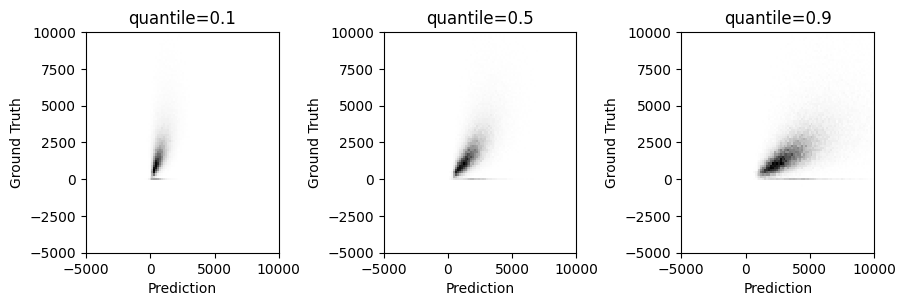

In [218]:
f, axs = plt.subplots(1, 3,  figsize=(9,3))
for c, q in enumerate(quantiles):
    y_pp = y_pred[c]*1000
    m = mean_pinball_loss(y_valid_gt, y_pp, sample_weight=sample_weights_valid, alpha=q)

    q_eval = np.mean(y_valid_gt <= y_pp)

    r2 = r2_score(y_valid_gt,y_pp)
    print(f'{q}: {m}, {q_eval}, {r2}')

    _ = axs[c].hist2d(np.squeeze(y_pp), np.squeeze(y_valid_gt), bins=(100, 100), 
                                         cmap=plt.cm.Greys, range=[[-5000, 10000], [-5000, 10000]])

    axs[c].set_xlabel('Prediction')
    axs[c].set_ylabel('Ground Truth')
    axs[c].set_title(f'quantile={q}')

plt.tight_layout(pad=0.5)    

## Hyperparameter search

This was performed on a cluster with the following grid for gridCV search with a single seed (0):

* learning rates = [0.001, 0.0001, 0.00003]
* embedding shapes (for cadinality <= 10, <= 20, > 20) = [[2,4,8],[2,6,11]]
* hidden layer sizes = [1000, 5000, 8000]
* hidden layer regularization types (L2 or max norm) = ['l2', 'l2', 'mn','mn','mn']
    * with corresponding regularization values = [0, 0.00001, 5, 8, 12]
* hidden layer dropout rates = [0.2, 0.5]

Simulations run with early stopping (patience = 50 epochs) for a maximum of 500 epochs.

All training/validation/testing was done on the feature engineered/augmented dataset.

### Performance of hyperparameter search

First column in the run results data frame (sorted by validation performance) shows mean pinball losses for validation set (weighted).

In [138]:
losses = dict()
losses_mn = dict()
percs = dict()
params = dict()
for cxx in range(1, 181):
    sName = os.path.join('results_mlp_run1', 'HistMLP_meta_'+str(cxx)+'.pickle')
    with open(sName, 'rb') as handle:
        dicts = pickle.load(handle)
    saveDict = dicts[0]
    paramDict = dicts[1]
    losses[cxx] = np.around(saveDict['valid_loss'], 4)
    percs[cxx] = np.around(saveDict['valid_perc'], 3)
    losses_mn[cxx] = np.mean(saveDict['valid_loss'])
    params[cxx] = paramDict

dataDict={'losses_mn':losses_mn.values()}
for k in params[1]:
    pVals = []
    for cxx in range(1, 181):
        pVals.append(params[cxx][k])
    dataDict[k] = pVals
dataDict['losses'] = losses.values()
dataDict['percs'] = percs.values()
dataDict['ids'] = losses.keys()
    
run1_results_df = pd.DataFrame(data = dataDict)
sorted_run1_results_df = run1_results_df.sort_values(by=['losses_mn'])
sorted_run1_results_df = sorted_run1_results_df.set_index('ids')
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    display(sorted_run1_results_df)#.head(30)

,losses_mn,learning_rate,embedding_o_dim1,embedding_o_dim2,embedding_o_dim3,embedding_reg,hidden_size,hidden_reg_type,hidden_reg_hp,hidden_dropout,out_reg_type,out_reg_hp,losses,percs
ids,,,,,,,,,,,,,,
118,378.223807,0.00010,2,6,11,0,8000,mn,8.00000,0.5,l2,0,"[20.5081, 72.0568, 339.1262, 454.4709, 677.3171, 712.2724, 656.1307, 327.9628, 144.1693]","[0.004, 0.023, 0.184, 0.27, 0.521, 0.742, 0.824, 0.971, 0.993]"
116,378.223807,0.00010,2,6,11,0,8000,mn,5.00000,0.5,l2,0,"[20.5081, 72.0568, 339.1262, 454.4709, 677.3171, 712.2724, 656.1307, 327.9628, 144.1693]","[0.004, 0.023, 0.184, 0.27, 0.521, 0.742, 0.824, 0.971, 0.993]"
120,378.223807,0.00010,2,6,11,0,8000,mn,12.00000,0.5,l2,0,"[20.5081, 72.0568, 339.1262, 454.4709, 677.3171, 712.2724, 656.1307, 327.9628, 144.1693]","[0.004, 0.023, 0.184, 0.27, 0.521, 0.742, 0.824, 0.971, 0.993]"
112,378.242418,0.00010,2,6,11,0,8000,l2,0.00000,0.5,l2,0,"[20.6105, 72.0953, 339.7568, 454.4305, 677.8893, 712.6777, 656.1475, 327.6725, 142.9017]","[0.004, 0.029, 0.19, 0.27, 0.524, 0.757, 0.835, 0.971, 0.994]"
115,378.516847,0.00010,2,6,11,0,8000,mn,5.00000,0.2,l2,0,"[20.7343, 72.169, 339.5984, 455.801, 677.8298, 711.5641, 656.0374, 329.4561, 143.4615]","[0.005, 0.018, 0.173, 0.272, 0.506, 0.737, 0.818, 0.968, 0.994]"
117,378.516847,0.00010,2,6,11,0,8000,mn,8.00000,0.2,l2,0,"[20.7343, 72.169, 339.5984, 455.801, 677.8298, 711.5641, 656.0374, 329.4561, 143.4615]","[0.005, 0.018, 0.173, 0.272, 0.506, 0.737, 0.818, 0.968, 0.994]"
119,378.516847,0.00010,2,6,11,0,8000,mn,12.00000,0.2,l2,0,"[20.7343, 72.169, 339.5984, 455.801, 677.8298, 711.5641, 656.0374, 329.4561, 143.4615]","[0.005, 0.018, 0.173, 0.272, 0.506, 0.737, 0.818, 0.968, 0.994]"
108,378.727098,0.00010,2,6,11,0,5000,mn,8.00000,0.5,l2,0,"[20.4889, 71.7123, 339.2791, 454.7709, 679.3366, 714.4051, 658.0227, 327.2305, 143.2978]","[0.003, 0.027, 0.162, 0.247, 0.511, 0.752, 0.825, 0.972, 0.994]"
110,378.727098,0.00010,2,6,11,0,5000,mn,12.00000,0.5,l2,0,"[20.4889, 71.7123, 339.2791, 454.7709, 679.3366, 714.4051, 658.0227, 327.2305, 143.2978]","[0.003, 0.027, 0.162, 0.247, 0.511, 0.752, 0.825, 0.972, 0.994]"


### Round 2

Another search was run with:
* With the option of a second layer
* A arger hidden layer 1 size
* Option of Layer norm
* Option of larger embedding dimensions

In [190]:
losses = dict()
losses_mn = dict()
percs = dict()
params = dict()
for cxx in range(1, 193):
    sName = os.path.join('results_mlp_run2', 'HistMLP_meta_'+str(cxx)+'.pickle')
    if not os.path.isfile(sName):
        continue
    with open(sName, 'rb') as handle:
        dicts = pickle.load(handle)
    saveDict = dicts[0]
    paramDict = dicts[1]
    losses[cxx] = np.around(saveDict['valid_loss'], 4)
    percs[cxx] = np.around(saveDict['valid_perc'], 3)
    losses_mn[cxx] = np.mean(saveDict['valid_loss'])
    params[cxx] = paramDict

dataDict={'losses_mn':losses_mn.values()}
for k in params[1]:
    pVals = []
    for cxx in range(1, 193):
        if cxx in params:
            pVals.append(params[cxx][k])
    dataDict[k] = pVals
dataDict['losses'] = losses.values()
dataDict['percs'] = percs.values()
dataDict['ids'] = losses.keys()
    
run2_results_df = pd.DataFrame(data = dataDict)
sorted_run2_results_df = run2_results_df.sort_values(by=['losses_mn'])
sorted_run2_results_df = sorted_run2_results_df.set_index('ids')
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    display(sorted_run2_results_df)#.head(30)

,losses_mn,learning_rate,embedding_o_dim1,embedding_o_dim2,embedding_o_dim3,embedding_reg,hidden_size,hidden_reg_type,hidden_reg_hp,hidden_dropout,out_reg_type,out_reg_hp,layer_norm1,gamma_reg,layer_norm2,hidden_size2,hidden_reg_hp2,hidden_dropout2,losses,percs
ids,,,,,,,,,,,,,,,,,,,,
4,377.690126,0.00010,2,6,11,0,12000,mn,5,0.5,l2,0,0,0.000,0,0,0,0.0,"[20.7694, 72.714, 339.9084, 453.9662, 675.8564, 710.305, 654.612, 326.9981, 144.0817]","[0.006, 0.029, 0.189, 0.27, 0.51, 0.744, 0.825, 0.972, 0.993]"
8,377.690126,0.00010,2,6,11,0,12000,mn,8,0.5,l2,0,0,0.000,0,0,0,0.0,"[20.7694, 72.714, 339.9084, 453.9662, 675.8564, 710.305, 654.612, 326.9981, 144.0817]","[0.006, 0.029, 0.189, 0.27, 0.51, 0.744, 0.825, 0.972, 0.993]"
52,378.143769,0.00010,2,6,18,0,12000,mn,5,0.5,l2,0,0,0.000,0,0,0,0.0,"[20.6057, 72.6516, 339.0234, 453.8938, 676.8558, 710.2954, 657.2747, 328.3541, 144.3394]","[0.004, 0.023, 0.175, 0.262, 0.521, 0.741, 0.808, 0.97, 0.993]"
56,378.143769,0.00010,2,6,18,0,12000,mn,8,0.5,l2,0,0,0.000,0,0,0,0.0,"[20.6057, 72.6516, 339.0234, 453.8938, 676.8558, 710.2954, 657.2747, 328.3541, 144.3394]","[0.004, 0.023, 0.175, 0.262, 0.521, 0.741, 0.808, 0.97, 0.993]"
152,378.688214,0.00003,2,6,18,0,12000,mn,8,0.5,l2,0,0,0.000,0,0,0,0.0,"[20.2884, 71.2081, 338.6984, 454.3823, 679.2332, 715.0784, 658.9409, 327.7492, 142.615]","[0.004, 0.024, 0.161, 0.252, 0.511, 0.748, 0.826, 0.973, 0.994]"
148,378.688214,0.00003,2,6,18,0,12000,mn,5,0.5,l2,0,0,0.000,0,0,0,0.0,"[20.2884, 71.2081, 338.6984, 454.3823, 679.2332, 715.0784, 658.9409, 327.7492, 142.615]","[0.004, 0.024, 0.161, 0.252, 0.511, 0.748, 0.826, 0.973, 0.994]"
104,379.081085,0.00003,2,6,11,0,12000,mn,8,0.5,l2,0,0,0.000,0,0,0,0.0,"[20.3401, 71.0501, 339.1747, 455.0041, 680.2951, 716.0825, 659.8156, 327.7341, 142.2335]","[0.003, 0.025, 0.167, 0.257, 0.5, 0.752, 0.826, 0.973, 0.994]"
100,379.081085,0.00003,2,6,11,0,12000,mn,5,0.5,l2,0,0,0.000,0,0,0,0.0,"[20.3401, 71.0501, 339.1747, 455.0041, 680.2951, 716.0825, 659.8156, 327.7341, 142.2335]","[0.003, 0.025, 0.167, 0.257, 0.5, 0.752, 0.826, 0.973, 0.994]"
18,386.208019,0.00010,2,6,11,0,4000,mn,5,0.5,l2,0,0,0.000,0,8000,5,0.5,"[20.7903, 74.4573, 340.6613, 456.4209, 677.9902, 718.8744, 668.2958, 347.5518, 170.8301]","[0.004, 0.03, 0.159, 0.23, 0.473, 0.699, 0.779, 0.955, 0.986]"


The best performer overall was a model with a single 12000 unit hidden layer, learning rate 0.0001, embedding dimensions 2,6,11, max norm hidden layer regularization (although this was flexible), dropout rate 0.5 and no layer norm.

## Performance Evaluation

Run with 10 seeds.

In [14]:
losses = dict()
train_losses_mn = dict()
test_losses_mn = dict()
valid_losses_mn = dict()
percs = dict()
for cxx in range(10):
    sName = os.path.join('results_mlp/results_seed', 'HistMLP_meta_'+str(cxx)+'.pickle')
    with open(sName, 'rb') as handle:
        dicts = pickle.load(handle)
    saveDict = dicts[0]
    paramDict = dicts[1]
    losses[cxx] = np.around(saveDict['test_loss'], 4)
    percs[cxx] = np.around(saveDict['test_perc'], 3)
    train_losses_mn[cxx] = np.mean(saveDict['train_loss'])
    test_losses_mn[cxx] = np.mean(saveDict['test_loss'])
    valid_losses_mn[cxx] = np.mean(saveDict['valid_loss'])

dataDict={'train_mean_loss':train_losses_mn.values(), 
          'valid_mean_loss':valid_losses_mn.values(), 
          'test_mean_loss':test_losses_mn.values()}
dataDict['losses'] = losses.values()
dataDict['percs'] = percs.values()
dataDict['seed'] = losses.keys()
    
run2_results_df = pd.DataFrame(data = dataDict)
sorted_run2_results_df = run2_results_df.sort_values(by=['test_mean_loss'])
sorted_run2_results_df = sorted_run2_results_df.set_index('seed')
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    display(sorted_run2_results_df)#.head(30)

,train_mean_loss,valid_mean_loss,test_mean_loss,losses,percs
seed,,,,,
0,342.537189,374.380230,373.988680,"[20.8437, 73.0006, 337.6738, 450.7258, 668.6323, 701.6519, 645.5409, 323.7285, 144.1006]","[0.005, 0.03, 0.173, 0.25, 0.5, 0.747, 0.833, 0.974, 0.994]"
7,344.724186,374.605414,374.227138,"[20.6676, 72.5869, 337.6033, 450.4539, 669.6151, 702.4331, 646.5793, 323.7345, 144.3705]","[0.005, 0.028, 0.178, 0.26, 0.521, 0.76, 0.833, 0.974, 0.994]"
1,342.615218,374.268746,374.277385,"[20.726, 73.0503, 337.8491, 451.0152, 669.1289, 702.2418, 646.431, 323.7352, 144.3189]","[0.004, 0.031, 0.18, 0.263, 0.509, 0.747, 0.828, 0.974, 0.994]"
6,346.865960,374.546907,374.341916,"[20.8198, 73.0359, 337.3642, 450.5293, 670.0058, 702.8342, 646.6863, 323.7608, 144.041]","[0.004, 0.032, 0.173, 0.263, 0.52, 0.757, 0.832, 0.975, 0.994]"
8,348.737134,374.818633,374.570831,"[20.7323, 72.3635, 337.5859, 451.2129, 670.2685, 703.7033, 647.3255, 323.8159, 144.1296]","[0.004, 0.026, 0.169, 0.258, 0.509, 0.757, 0.835, 0.973, 0.994]"
2,348.439754,375.044392,374.665149,"[20.6306, 72.6746, 337.6606, 451.4123, 670.5468, 704.1287, 647.1405, 324.0629, 143.7293]","[0.005, 0.032, 0.177, 0.261, 0.506, 0.759, 0.831, 0.975, 0.994]"
3,348.286228,374.959063,374.726163,"[20.6147, 73.1584, 337.4484, 451.0264, 670.6948, 704.023, 647.2753, 323.8012, 144.4933]","[0.004, 0.036, 0.172, 0.251, 0.502, 0.748, 0.837, 0.973, 0.994]"
4,347.763809,374.776120,374.757105,"[20.741, 72.9618, 337.896, 451.2392, 669.8012, 703.3706, 647.934, 324.2014, 144.6687]","[0.005, 0.033, 0.176, 0.249, 0.496, 0.744, 0.828, 0.973, 0.994]"
5,339.981048,375.387390,374.800321,"[20.8091, 73.8329, 337.6431, 451.9, 670.4806, 702.1569, 646.887, 323.7274, 145.7658]","[0.006, 0.035, 0.168, 0.27, 0.522, 0.746, 0.821, 0.972, 0.993]"


<IPython.core.display.Javascript object>


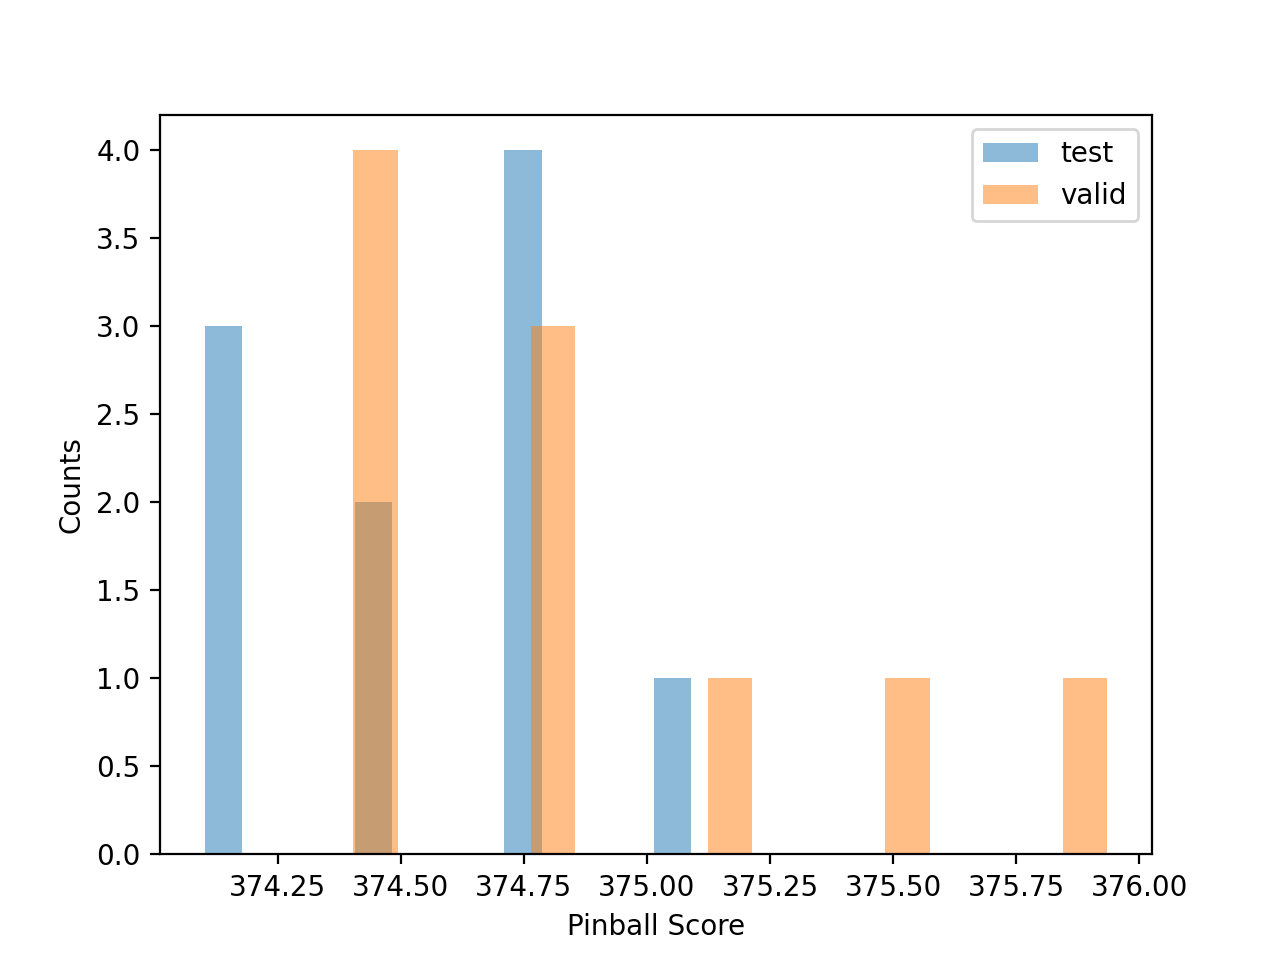

In [22]:
plt.hist(dataDict['test_mean_loss'], bins = 4, rwidth=0.25, alpha=0.5, label='test')
plt.hist(dataDict['valid_mean_loss'], bins = 5, rwidth=0.25, alpha=0.5, label='valid')
plt.xlabel('Pinball Score')
plt.ylabel('Counts')
plt.legend()

Best performing network still underperforms compared to XGBoost on the test set (and the validation set). 

Looking at the predictions for the project's test set from this model, we see:

In [26]:
best_seed = np.argmin(dataDict['test_mean_loss'])

results_df = pd.read_csv(os.path.join('results_mlp/results_seed', f'results_mlp{best_seed}.csv'),
                      header = 0,
                      index_col='id')
results_df.head()

,q1,q2,q3,q4,q5,q6,q7,q8,q9
id,,,,,,,,,
741875,-155.366486,72.447960,451.837189,612.312134,904.527283,1384.458740,1634.699951,4212.286133,9191.027344
741876,-770.002808,93.170662,1324.278076,1639.694458,2332.872803,3159.627441,3470.502441,5170.249023,12195.855469
741877,-89.925629,9.844169,195.920883,274.812347,373.395660,740.782043,939.892517,3584.156494,8283.693359
741878,-154.696671,87.568741,774.441528,1002.985962,1819.788574,2854.935059,3316.236084,7044.193359,16821.708984
741879,-25.402475,276.980835,1222.790405,1511.994385,2062.720459,3008.432373,3629.528076,7575.303223,14671.650391


## Hidden layer representation analysis

In [28]:
model = keras.models.load_model(f'results_mlp/model{best_seed}', compile = False)

6956/6956 [==============================] - 24s 3ms/step


<IPython.core.display.Javascript object>


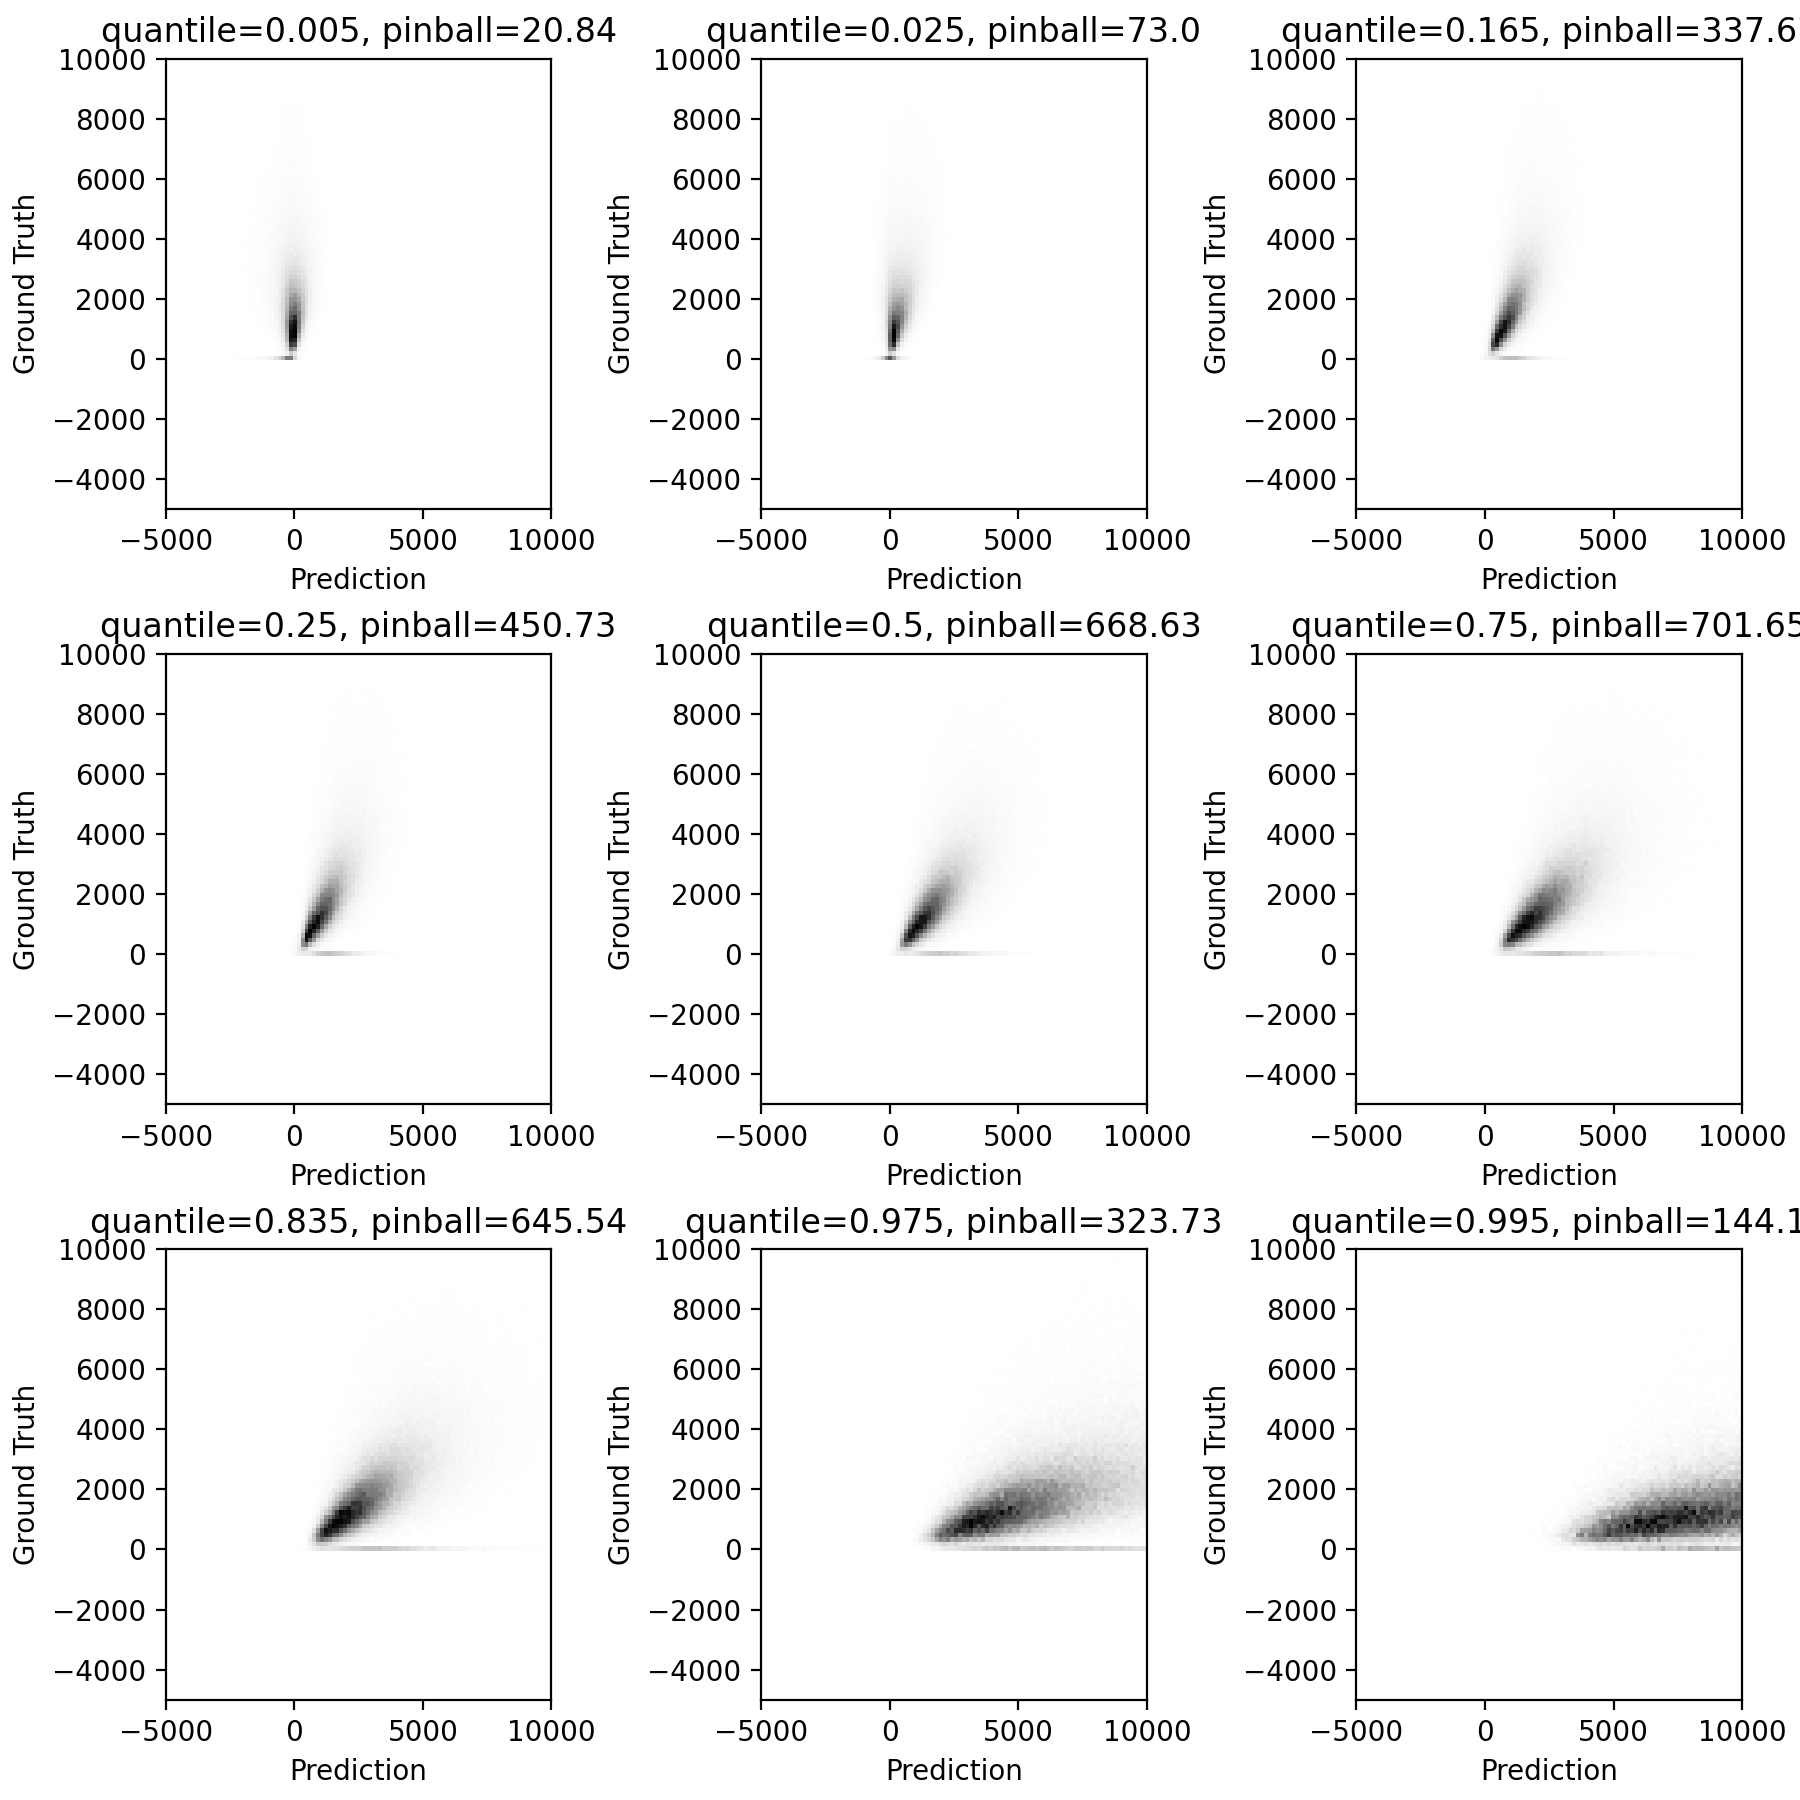

In [29]:
trueQuantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
y_pred = model.predict(X_test_inputs)
f, axs = plt.subplots(3, 3,  figsize=(9,9))
for c, q in enumerate(trueQuantiles):
    y_pp = y_pred[c]*1000
    m = mean_pinball_loss(y_test_gt, y_pp, sample_weight=sample_weights_test, alpha=q)

    q_eval = np.mean(y_test_gt <= y_pp)

    r2 = r2_score(y_test_gt,y_pp)
#     print(f'{q}: {m}, {q_eval}')#, {r2}')
    
    ax_yind = c%3
    ax_xind = c//3

    _ = axs[ax_xind, ax_yind].hist2d(np.squeeze(y_pp), np.squeeze(y_test_gt), bins=(100, 100), 
                                         cmap=plt.cm.Greys, range=[[-5000, 10000], [-5000, 10000]])

    axs[ax_xind, ax_yind].set_xlabel('Prediction')
    axs[ax_xind, ax_yind].set_ylabel('Ground Truth')
    axs[ax_xind, ax_yind].set_title(f'quantile={q}, pinball={np.around(m,2)}')

plt.tight_layout(pad=0.5)    

In comparison to similar plots for the best performing XGBoost model, these plots clearly appear more diffuse, which is indicative of its lower accuracy. Less diffuse distributions, instead, are indicative of tighter quantile predictions.

## Hiden Layer Representation Analysis

In [46]:
### Recreate network until hidden layer

In [30]:
cat_input_dim = [2, 6, 5, 5, 18, 56, 19]
cat_output_dim = []
for c in cat_input_dim:
    if c <= 10:
        o_dim = paramDict['embedding_o_dim1']
    elif c <= 20:
        o_dim = paramDict['embedding_o_dim2']
    else:
        o_dim = paramDict['embedding_o_dim3']
    cat_output_dim.append(o_dim)
    
# construct categorical inputs
catEmbeddings = []
catInputs = []
for i in range(len(catCols)):
    catInput_i = keras.Input(shape=(1,))    
    catInputs.append(catInput_i)
    emb_i = keras.layers.Embedding(cat_input_dim[i], 
                                   cat_output_dim[i],
                                   name = f'emb_{i}')
    catEmbeddings.append(keras.layers.Flatten()(emb_i(catInput_i)))
    
# numerical inputs
numInputs = keras.Input(shape=(18,))

# construct overal network input
netInput = keras.layers.concatenate(catEmbeddings+[numInputs])

# hidden layer
if paramDict['hidden_reg_type'] == 'mn':
    dense1 = keras.layers.Dense(paramDict['hidden_size'], 
                                activation="relu",
                                kernel_constraint=keras.constraints.MaxNorm(paramDict['hidden_reg_hp']),
                                name = 'hidden')
else:
    dense1 = keras.layers.Dense(paramDict['hidden_size'], activation="relu", name = 'hidden')

hidden1 = dense1(netInput)

modelPart = keras.Model(inputs=catInputs+[numInputs], outputs=hidden1)

In [32]:
# Copy over weights from original model

layerMaps = {'embedding':'emb_0',
            'embedding_1':'emb_1',
            'embedding_2':'emb_2',
            'embedding_3':'emb_3',
            'embedding_4':'emb_4',
            'embedding_5':'emb_5',
            'embedding_6':'emb_6',
            'dense' : 'hidden'}

for l in layerMaps:
    modelPart.get_layer(layerMaps[l]).set_weights(model.get_layer(l).get_weights())

In [33]:
# Get hidden layer activations
activations = modelPart.predict(X_test_inputs)

6956/6956 [==============================] - 20s 3ms/step


### Generate and plot Principal Components

In [35]:
pcaXform = IncrementalPCA(n_components=7, batch_size=500)

In [36]:
activations_sparse = sparse.csr_matrix(activations)

In [37]:
act_scores = pcaXform.fit_transform(activations_sparse)

<IPython.core.display.Javascript object>


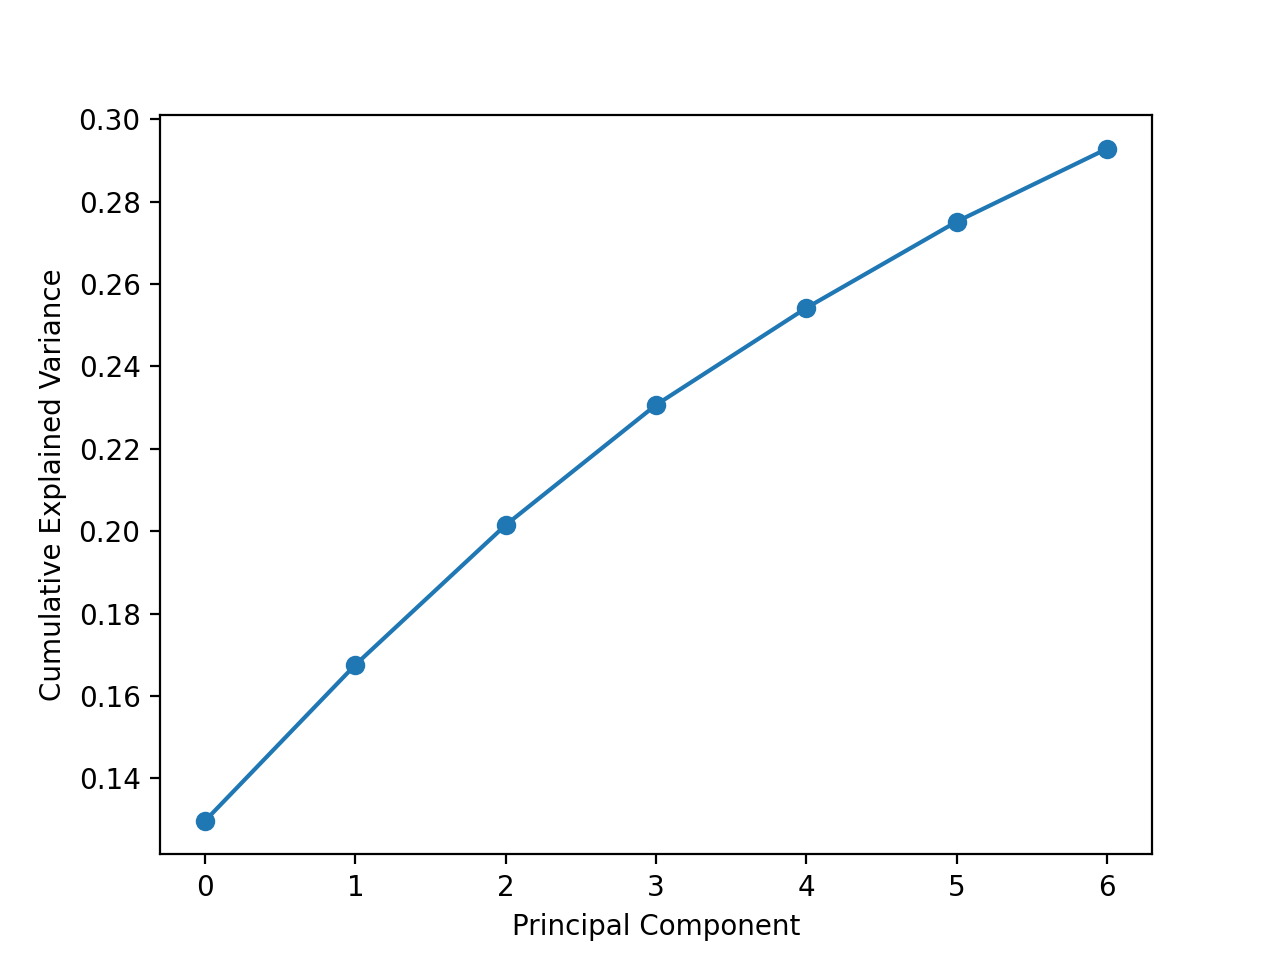

Text(0, 0.5, 'Cumulative Explained Variance')

In [38]:
plt.plot(np.cumsum(pcaXform.explained_variance_ratio_),'o-')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')

The plot above suggests that the internal representations are not low-dimensional, despite the outputs being constrained to 9 dimensions at most. 

Interestingly, running this analysis when the network was trained on 50 epochs, instead of 500, showed the representations to be lower dimensional (50% explained variance by first 3 dimensions and 70% explained variance by first 7 dimensionals), demonstrating that the dimensionality increases with training.

In [39]:
c_p = stats.percentileofscore(np.squeeze(y_test_gt), np.squeeze(y_test_gt))

In [40]:
inds = np.random.choice(act_scores.shape[0], size=1000, replace=False)

<IPython.core.display.Javascript object>


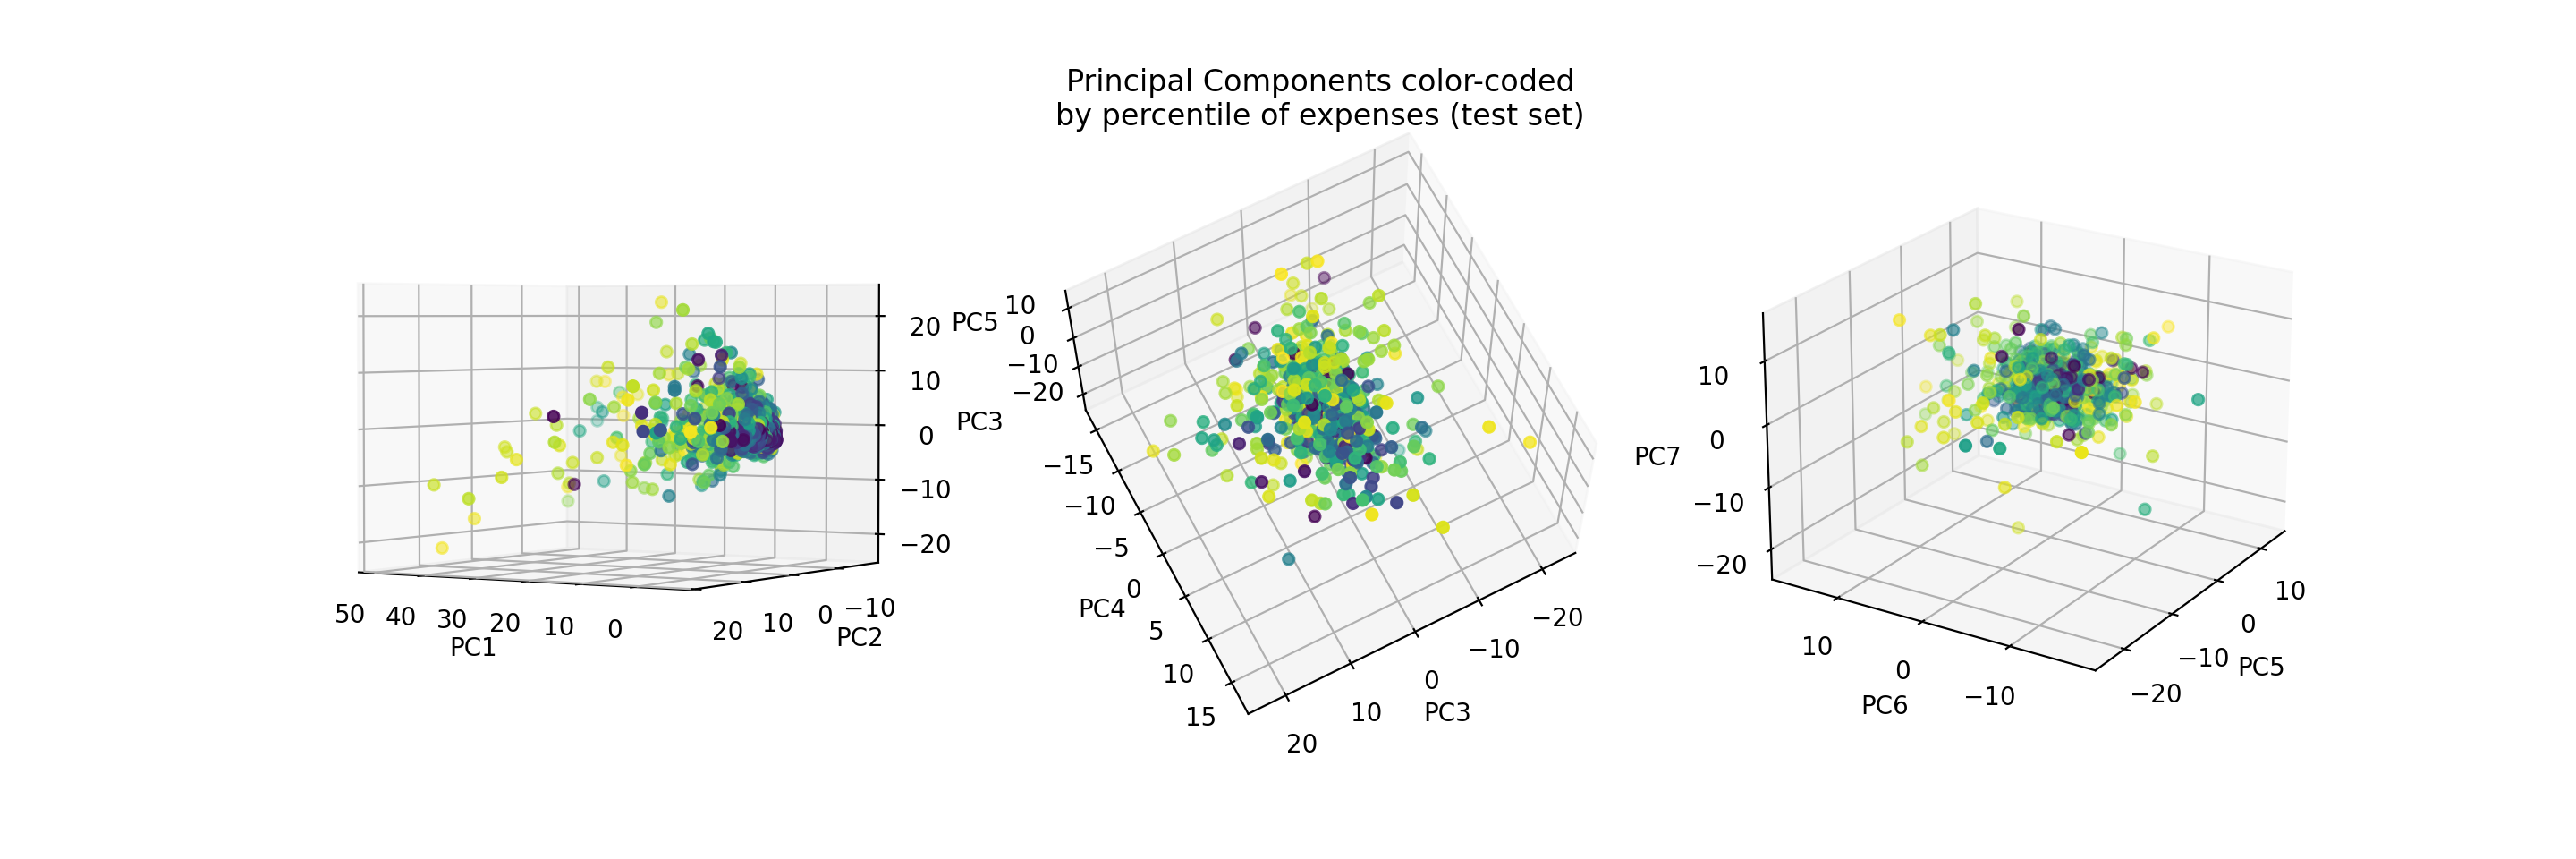

Text(0.5, 0, 'PC7')

In [47]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=plt.figaspect(0.3333))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter3D(act_scores[inds,0], act_scores[inds,1], act_scores[inds,2], c=c_p[inds])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.scatter3D(act_scores[inds,2], act_scores[inds,3], act_scores[inds,4], c=c_p[inds])
ax.set_xlabel('PC3')
ax.set_ylabel('PC4')
ax.set_zlabel('PC5')
ax.set_title('Principal Components color-coded\nby percentile of expenses (test set)')
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter3D(act_scores[inds,4], act_scores[inds,5], act_scores[inds,6], c=c_p[inds])
ax.set_xlabel('PC5')
ax.set_ylabel('PC6')
ax.set_zlabel('PC7')

Points seem to be linearly organized along PCs 1 and 2 by expense. However, another mode of representation of the dependent expense variable appears to be an outward radiation by expense, with samples corresponding to higher expense encoded at a larger radius (see middle and last plot). 
It is possible that non-linear transformations such as UMAP or t-SNE may produce better separation by expense.

Importantly, this would help identify expense clusters and gradients towards a more nuanced (compared to the brief shared with this problem) factor analysis to help identify subpopulations by their spending habits.

A narrower, deeper network architecture, optionally with a variational bayes component, may also contribute towards this goal.